<table width="100%"><tr><td align="left">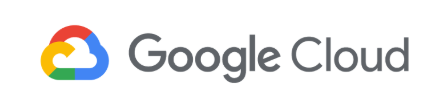</td><td align="right">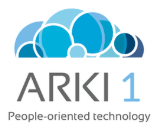</td></tr></table>

<h1>Visão Geral IoT no GCP - Exercício fim-a-fim</h1>

<h2>Tarefa 1: Preparação</h2>

<h3>A - Criar intervalo de armazenamento no Cloud Storage</h3>
Execute o comando a seguir para ter certeza que está no projeto correto. Se não estiver, descomente a linha seguinte e execute novamente para conectar-se no projeto correto.<br/>

In [1]:
!echo $(gcloud config get-value project)
#!gcloud config set project active-bolt-265320

active-bolt-265320


Execute o código a seguir para criar o intervalo:

In [16]:
!gsutil mb gs://$(gcloud config get-value project)

Creating gs://active-bolt-265320/...
ServiceException: 409 Bucket active-bolt-265320 already exists.


<h3>B - Criar infraestrutura minima para obter dados para a simulação</h3>
Neste exercício vamos ler mensagens de um tópico público do Pub/Sub com dados em tempo real e vamos reenviar essas mensagens simulando um sensor enviando via IoT (utilizaremos as mensagens como se fossem geradas por um sensor de nossa propriedade).<br/>

Execute o código abaixo para criar a assinatura para os dados públicos de taxis de NY que utilizaremos no exercício.

In [251]:
!gcloud pubsub subscriptions create bridge-taxi-iot --topic-project=pubsub-public-data --topic=taxirides-realtime

Created subscription [projects/active-bolt-265320/subscriptions/bridge-taxi-iot].


<b>Verifique se as mensagens estão sendo recebidas</b><br/>
Como esse tópico público recebe muitas mensagens por segundo, a qualquer momento podemos fazer um pull e ver uma mensagem. Execute o comando abaixo para examinar uma dessas mensagens:<br/>


In [300]:
!gcloud pubsub subscriptions pull bridge-taxi-iot --auto-ack

┌────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┬──────────────────┬────────────────────────────────────┐
│                                                                                                                                  DATA                                                                                                                                  │    MESSAGE_ID    │             ATTRIBUTES             │
├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼──────────────────┼────────────────────────────────────┤
│ {"ride_id":"3cf9cbfc-9876-49b

<h2>Tarefa 2: Projeto da rede IoT para os sensores simulados</h2>

Nossos sensores são GPSs que enviam a posição de um veículo. Para configurar o software (nesse exercício não projetaremos o hardware dos sensores, que poderia ser um módulo de GPS e um módulo de celular ligados num RaspberryPi, por exemplo) vamos analisar as mensanges que o GPS nos envia.<br/>
<br/>
<b>I - Decodifique as mensagens</b><br/>

Vamos então desenvolver código Python que vai lidar com esses dados. No nosso cenário simulado, o sensor teria então que ter a capacidade de executar Python, ou, no exemplo de conectar sensores num RaspberryPi, este serviria como gateway para esses sensores. <br/>
<h3>Gateways (portais)</h3>
O termo "gateway" traduz-se para "portal". É um módulo de hardware, abaixo da nuvem, que serve para conecar um ou mais sensores e/ou atuadores.<br/>
<br/>
Existem dispositivos que não necessitam de gateways (podem se conectar diretamente na Internet, tem capacidade de envio de mensagens MQTT, pode ser configurado, normalmente tem alguma capacidade de processamento, mesmo que limitada).<br/>
<br/>
Para sensores menos sofisticados, ou para criar conjuntos de sensores/atuadores que se conectam por um ponto centralizado, ou ainda para utilizar recursos de processamento mais sofisticados, pode-se utilizar os gateways.<br/>
<br/>
As redes IoT aceitam conexões diretamente de dispositivos ou através de Gateways, e no IoT Core você cria registros dos dois tipos.<br/>
<br/>
Neste exercício vamos conectar um gateway simulado. Vamos utilizar código Python, de forma que o nosso gateway teria que ter capacidade de processamento avançada. Note que tudo isso é opcional numa rede IoT: pode-se conectar um RaspberryPi, por exemplo, como dispositivo ou como portal - a escolha da arquitetura é de quem projeta a rede.<br/>
<br/>
<b>II - Código local para executar no gateway</b><br/>
Vamos utilizar o Cloud Shell para simular um gateway. Execute o código abaixo para criar o arquivo python:<br/> 

O próximo bloco pode ser executado neste notebook (o %%writefile magic vai criar o arquivo, depois copiaremos para o Storage, e por fim copiaremos para o Cloud Shell quando ele for executado).

In [305]:
%%writefile gateway.py

# esta funcao cria o pacote de dados que vai ser enviado para a rede IoT na nuvem
import json


def GPS_data( msg ):
    
    # recupera a parte em base64 da mensagem do GPS
    msg = json.loads( msg )

    # cria o payload (pacote de dados)
    latitude = msg[ "latitude" ]
    longitude = msg[ "longitude" ]
    ts = msg[ "timestamp" ]

    return '{ "ts": "' + str( ts ) + '", "latitude": ' + str( latitude ) + ', "longitude": ' + str( longitude ) + '}'


    
# codigo principal do gateway
import os
import time

# inicia um loop (em teoria, o gateway funciona 24/7 ou é ativado por algum
#  atuador industrial ou residencial - um interrupetor, um comando para o 
#  Google Home, etc)

# na nossa simulação vamos ler 5 mensagens depois encerrar
msg_num = 0

while msg_num < 5:

    # lê dados dos sensores
        # (nessa simulação estamos lendo de um topico publico do Pub/Sub,
        #  mas nesse bloco poderiamos estar lendo de um hardware de sensor
        #  real)

    # embora o topico de taxis de NY seja muito ativo, com picos de varias 
    # msgs por segundo, em alguns momentos ele pode nao retornar mensagem 
    # nenhuma, entao temos que ter certeza q recebemos uma msg
    
    msg = "Listed 0 items."
    
    while msg == "Listed 0 items.":
        msg = os.popen( "gcloud pubsub subscriptions pull bridge-taxi-iot --auto-ack" ).read().strip()
        
        if msg == "Listed 0 items.":
            print( "nenhum dado novo no sensor" )
            time.sleep( 1 )
        
    msg = msg[ ( msg.find( '{"ride_id' )): ]
    msg = msg[ 0:( msg.find( "}" ) + 1 )]

    # cria o pacote de dados
    payload = GPS_data( msg )
    msg_num += 1
    
    print( payload )


Overwriting gateway.py


Execute o código a seguir para copiar o arquivo python para o Cloud Storage:

In [285]:
!gsutil cp gateway.py gs://$(gcloud config get-value project)

Copying file://gateway.py [Content-Type=text/x-python]...
/ [1 files][  1.2 KiB/  1.2 KiB]                                                
Operation completed over 1 objects/1.2 KiB.                                      


<b>[EXECUTE NO CLOUD SHELL]</b> Copie o código abaixo e execute no Cloud Shell para observar o codigo simulando captar dados de GPSs. Por enquanto ele faz somente isso. Vamos acrescentar nesse arquivo num passo posterior a parte que envia a mensagem para a rede IoT.

<h2>Tarefa 3: Preparando a Segurança de Conexão</h2>

IoT implica em conexões seguras para evitar que redes de sensores sejam hackeadas. Para citar um exemplo real, mas de antes do aparecimento do IoT, redes de controle industrial no Iraque foram invadidas e centrifugas de enriquecimento de urânio foram desativadas, porque nessas centrifugas existiam sistemas de controle que podiam ser acessados via Internet, mas que não ofereciam muita segurança.<br/>
<br/>
Num cenário mais real e mais próximo do nosso exemplo, um concorrente poderia tentar hackear GPSs num app de taxis para prejudicar o nível de serviço (forçar cancelamento de viagens, atrasos, etc).<br/>
<br/>
O IoT evita esses problemas criando conexões segura de/para os dispositos e gateways.<br/>

<b>I - Autenticação</b><br/>
Os dispositivos precisam se autenticar para o broker (o aplicativo na nuvem que recebe e encaminha as mensagens) para provar que são os sensores que a rede tem registrada (isso evita que injetemos dados falsos numa rede fingindo ser os dispositivos).<br/>
<br/>
Para fazer isso somamos duas técnicas: criamos tokens de  autenticação utilizando a tecnologia de JWT (JSON web tokens) que é uma implementação de um padrão industrial para esse fim. E esses tokens são criptografados utilizando a tecnologia de assinatura por chave privada / chave pública, muito comum em criptografia.<br/>
<br/>
O processo é o inverso da criptografia normal: utiliza-se a chave privada para assinar e a pública para decodificar. A chave privada é mantida nos dispositivos, o que garante que somente o dispositivo poderia ter enviado o token, tornando impossível injetar dados falsos na rede fingindo ser um dos sensores.<br/>
<br/>
Para nosso exercício será preciso gerar um par de chave privada / chave pública para autenticar-se no IoT core.<br/>
Execute o código abaixo:

In [27]:
!openssl req -x509 -newkey rsa:2048 -keyout rsa_private.pem -nodes -out rsa_cert.pem -subj "/CN=unused"
!openssl rsa -in rsa_private.pem -pubout -out rsa_public.pem


Generating a RSA private key
....................+++++
...................+++++
writing new private key to 'rsa_private.pem'
-----
writing RSA key


Execute o código a seguir para copiar os arquivos de chave para o Cloud Storage. Vamos utiliza-los num passo posterior.

In [166]:
!gsutil cp rsa* gs://$(gcloud config get-value project)

Copying file://rsa_cert.pem [Content-Type=application/octet-stream]...
Copying file://rsa_private.pem [Content-Type=application/octet-stream]...       
Copying file://rsa_public.pem [Content-Type=application/octet-stream]...        
- [3 files][  3.2 KiB/  3.2 KiB]                                                
Operation completed over 3 objects/3.2 KiB.                                      


Execute a célula abaixo para acrescentar o código de autenticação no arquivo gateway.py. Por enquanto vamos apenas analisar o código, ele só será executado mais adiante quando acrescentarmos a capacidade de envio de mensagens MQTT.<br/>

In [306]:
%%writefile --a gateway.py 

    # cria o token de autenticacao utilizando a tecnologia jwt
    import datetime
    import jwt


    def create_jwt( project_id, private_key_fname ):

        token = {
            # o momento em que o token foi criado
            'iat': datetime.datetime.utcnow(),

            # momento em que o token expira. Em geral nao devemos usar intervalos tao grandes
            # estamos usando meia hora para fins deste exercico
            'exp': datetime.datetime.utcnow() + 
                datetime.timedelta( minutes=30 ),

            # no campo "audiencia" colocamos o project_id
            'aud': project_id
        }

        # le o arquivo com a chave privada
        from google.cloud import storage
        storage_client = storage.Client()

            # note que estamos usando hardcoded um bucket com o mesmo nome do projeto
        bucket = storage_client.get_bucket( project_id )

            # nome do arquivo tem que ser o caminho completo
        blob = bucket.blob( private_key_fname )

        private_key = blob.download_as_string()

        # criptografa o token. Note que temos que indicar o tipo de chave 
        # (algoritmo de criptografia utilizado na assinatura)
        return jwt.encode( token, private_key, algorithm='RS256' )


Appending to gateway.py


<h2>Tarefa 4: Configurar o dispositivo para autenticar na rede IoT e enviar mensagens</h2>

Vamos incluir no código agora a conexão com a rede utilizando o protocolo MQTT como se estivessemos conectando de um dispositivo. Para garantir a segurança da comunicação ainda diversos passos tem que ser implementados.<br/>
<br/>
No Cloud IoT Core do GCP, para que o dispositivo possa se comunicar com a rede ele deve estar registrado. Neste momento, vamos incluir na função os nomes para o registro da rede IoT e para o dispositivo. Vamos criar os registros para o broker e do dispositivo num passo a seguir.<br/>
<br/>
Execute o código abaixo para acrescentar essa parte no arquivo gateway.py.

In [307]:
%%writefile --a gateway.py

    connected = 255 # maior que zero = conexao recusada

    # as redes IoT precisam ser registradas em algumas regioes no GCP. Vamos utilizar
    # us-central1 no nosso exercicio

    cloud_region = 'us-central1'

    # um registry é um registro geral de rede IoT (identifica toda uma rede)
    registry_id = "taxi-iot-broker"

        # utilizando o nome do projeto como nome do dispositivo
        # Num caso real, cada dispositivo precisa ter um nome único

    project_id = os.popen( 'gcloud config get-value project' ).read().strip() 
    device_id = project_id

    # no python vamos criar um cliente de MQTT para lidar com todos os detalhes do
    # protocolo. Esse cliente precisa ser identificado seguindo regras do Core IoT

    client_id = 'projects/{}/locations/{}/registries/{}/devices/{}'.format(
            project_id, cloud_region, registry_id, device_id )

    # utilizamos o pacote paho para criar o cliente MQTT
    import paho.mqtt.client as mqtt

    client = mqtt.Client( client_id=client_id )

    # uma possibilidade de login no padrao MQTT é um par usuario / senha

        # No Google Cloud IoT Core o campo username é ignorado, e o campo
        # password é usado para transmitir o JWT para autorizar o dispositivo
        
    client.username_pw_set( username='unused', password=create_jwt( project_id, "rsa_private.pem" ))

    # precisamos ativar o suporte a SSL/TLS para utilizar transporte criptografado pela Internet
    client.tls_set( ca_certs=None, certfile=None, keyfile=None, ciphers=None )

    # a conexao é assincrona, um callback de on_connect sera acionado quando a conexao ocorrer
    def mqtt_connect( client, userdata, flags, rc ):
        global connected
        connected = rc

    client.on_connect=mqtt_connect 

    # depois de todos os configs efetuados, finalmente conecta com a ponte de IoT do GCP
    # o bridge de IoT do GCP é o ponto de entrada na nuvem 
    # abaixo o endereço padrão do IoT Core
    
    mqtt_bridge_hostname = "mqtt.googleapis.com"
    mqtt_bridge_port = 8883

    # inicia a conexao
    client.connect( mqtt_bridge_hostname, mqtt_bridge_port )

    # a conexao é assincrona, temos q esperar em loop até ela ocorrer
    # ou até um timeout
    client.loop_start() 

    # a conexao normalmente é feita em um segundo ou alguns poucos, mas pode levar mais tempo
    # Estamos utilizando 60 segundos neste exercicio
    t_end = time.time() + 60 

    while time.time() < t_end and connected > 0:
        time.sleep( 1 )

    print( "conexao MQTT -> status: " + ( "ok" if connected == 0 else "erro: " + str( connected )))

    # note que nao estamos checando connected == 0 (q indica conexao com sucesso )
    # para continuar, o que quer dizer q se a conexao falhar por algum motivo 
    # (sem conexao de internet, p ex) a mensagem nao vai ser enviada 
    # (mas nao vai levantar erro)

    # o padrao MQTT é um padrao de fila, logo utiliza, assim como o Pub/Sub, o padrao de projeto
    # publisher / subscriber. Mensagens são publicadas (nesse caso o dispositivo é considerado
    # um publicador) para tópicos.

    # O MQTT tem topicos padrao para envio de mensagens: events e state. É possivel criar 
    # conjuntos de subtópicos, no entanto, para melhorar o gerenciamento de mensagens.

    mqtt_topic = '/devices/{}/events'.format( device_id )

    # qos (quality of service) = 1 indica entrega pelo menos uma vez 
    # (mesma qualidade do Pub/Sub)

    client.publish( mqtt_topic, json.dumps( payload ), qos=1 )

    print( "publicado payload " )

    client.loop_stop()    #Stop loop 
    client.disconnect() # disconnect


Appending to gateway.py


Execute o código abaixo para copiar para o intervalo no Cloud Storage:

In [304]:
!gsutil cp gateway.py gs://$(gcloud config get-value project)   
    

Copying file://gateway.py [Content-Type=text/x-python]...
/ [1 files][  6.3 KiB/  6.3 KiB]                                                
Operation completed over 1 objects/6.3 KiB.                                      


<b>[EXECUTE NO CLOUD SHELL]</b> Copie o código abaixo e execute no Cloud Shell para instalar as dependências necessárias. O código está pronto, mas não podemos executá-lo ainda: temos que criar o registro de rede e o do dispositivo no IoT Core.

<h2>Tarefa 5: Configurar a rede IoT no GCP</h2>

Para configurar a parte da rede na nuvem, criamos um registro de rede IoT e um registro para cada dispositivo.<br/>
<br/>
No entanto, o Core IoT publica as mensagens em tópicos do Pub/Sub, então precisamos criar antes um tópico para receber as mensagens.<br/>
<br/>
Execute o código abaixo para criar um tópico do Pub/Sub:

In [2]:
!gcloud pubsub topics create taxi-iot-events

Created topic [projects/active-bolt-265320/topics/taxi-iot-events].


Agora precisamos criar um registro de rede de IoT (registry). A descrição do Google para o registry é:<br/>
<br/>
<i>"Um registro que permite agrupar dispositivos e configurar propriedades compartilhadas, como protocolo de comunicação, local para armazenamento de dados e tópicos do Pub/Sub."</i><br/>
<br/>
Execute o código abaixo para criar o registro da rede de IoT:

In [290]:
!gcloud services enable cloudiot.googleapis.com
!gcloud iot registries create taxi-iot-broker --event-notification-config=topic=taxi-iot-events --region=us-central1 

ERROR: (gcloud.iot.registries.create) ALREADY_EXISTS: A registry with the parent 'projects/active-bolt-265320/locations/us-central1' and ID 'taxi-iot-broker' already exists.


Em seguida precisamos registrar o dispositivo. Execute o código abaixo para registrar o dispositivo na rede que acabamos de criar. Observe que estamos utilizando o nome do projeto como nome do dispositivo porque foi o que fizemos no código da Cloud Function.<br/>
<br/>
Note também que informamos a chave pública que vai permitir que a rede tenha certeza que está sendo contatada pelo equipamento correto.

In [291]:
!gcloud iot devices create $(gcloud config get-value project) --registry=taxi-iot-broker --public-key path=rsa_cert.pem,type=rs256 --region=us-central1

ERROR: (gcloud.iot.devices.create) ALREADY_EXISTS: A device with the parent 'projects/active-bolt-265320/locations/us-central1/registries/taxi-iot-broker' and ID 'active-bolt-265320' already exists.


<h2>Testando a rede</h2>

Com tudo pronto, deve ser possivel ver as mensagens do nosso sensor chegando no tópico do Pub/Sub. Vamos inicialmente criar uma subscrição para o tópico de eventos da rede IoT (se não existir nenhuma inscrição o Pub/Sub não mantém mensagens, todas seriam apagadas).

In [295]:
!gcloud pubsub subscriptions create ouvir-eventos-taxi --topic=taxi-iot-events --topic-project=$(gcloud config get-value project)

ERROR: Failed to create subscription [projects/active-bolt-265320/subscriptions/ouvir-eventos-taxi]: Resource already exists in the project (resource=ouvir-eventos-taxi).
ERROR: (gcloud.pubsub.subscriptions.create) Failed to create the following: [ouvir-eventos-taxi].


<b>[EXECUTE NO CLOUDSHELL]</b> Copie o conteúdo da célula a seguir e execute no Cloud Shell para rodar nosso código de sensor simulado. 

Se tudo estiver certo, podemos executar o comando a seguir e coletar mensagens do tópico de eventos no Pub/Sub para a nossa rede IoT. Observe que esse passo é coletar na nuvem as mensagens que foram enviadas de fora da nuvem, pelos sensores.

In [308]:
!gcloud pubsub subscriptions pull ouvir-eventos-taxi --auto-ack

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┬──────────────────┬────────────────────────────────────┐
│                                                         DATA                                                        │    MESSAGE_ID    │             ATTRIBUTES             │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼──────────────────┼────────────────────────────────────┤
│ "{ \"ts\": \"2020-06-24T12:11:13.4403-04:00\", \"latitude\": 40.73303000000001, \"longitude\": -73.95473000000001}" │ 1298257938767180 │ deviceId=active-bolt-265320        │
│                                                                                                                     │                  │ deviceNumId=2712456198448625       │
│                                                                                                                     │ 

<h2>Conclusão</h2>

Embora o feito aqui pareça ser uma forma complicada de utilizar o Pub/Sub, na realidade exatamente o mesmo procedimento poderia ser criado para uma rede de sensores fisicos.<br/>
<br/>
Por exemplo, bastaria instalar um sensor GPS real num automóvel, e instalar um gateway de comunicação capaz de executar nosso código Python (por exemplo um Raspberry Pi com um módulo de celular para comunicação).<br/>
<br/>
Provavelmente teriamos algumas linhas de código a mais para utilizar a conexão de dados do módulo de celular, e linhas para capturar os dados do GPS que dependem de cada fabricante de sensor.<br/>
<br/>
No entanto, todo o restante seria igual ao deste exercício, e a partir daí teríamos um (ou mais) taxis enviando dados para o GCP. Os dados acabariam então no tópico de eventos do Pub/Sub para a rede IoT.<br/>
<br/>
É possível muito mais, como por exemplo enviar comandos para os dispositivos, configurações, etc, bem como criar uma estrutura mais complexa de tópicos no Pub/Sub para lidar com diferentes tipos de evento.<br/>
<br/>
Podemos usar estes princípios então para criar redes industriais de controle, ou redes de automação residencial, ou aplicativos que controlem muitos dispositivos (como um app de táxis por exemplo, ou um sistema para controlar estacionamentos), e etc.<br/>
<br/>
Em cenários de automação residencial, podemos ter um único gateway (um unico Raspberry Pi por ex) e sensores menos inteligentes com módulos de wi-fi comunicando-se com o gateway, montando a rede inteira com comunicação via o wi-fi residencial. Com poucas alterações no código deste exercício podemos por exemplo enviar uma mensagem de um celular para o Pub/Sub que então enviaria uma mensagem para um sensor para desligar as luzes da casa, por exemplo.<br/>

<h2>Para adaptar este exercício para rodar localmente</h2>

Este exercício simulou o envio de dados, mas como usamos o Cloud Shell, na prática enviamos dados de dentro da nuvem para o broker, também na nuvem.<br/>
<br/>
No entanto, como isso foi feito pelo MQTT e IoT, o Cloud Shell na pratica abriu uma conexão com o broker exatamente da mesma forma que teria feito se estivessemos fora da nuvem - ou seja, o mesmo código deste exercício, quase sem alterações, pode ser executado num computador local fora do GCP - ou mesmo num RaspberryPi, por exemplo.<br/>
<br/>
As alterações que teriam que ser feitas no código deste exercicio seriam:<br/>
<b>1 - Remover a leitura de mensagens dos taxis de NY (que só funciona dentro da nuvem)</b><br/>
Neste passo temos que ler dados dos nossos sensores (ou, para simular dados, podemos simplesmente utilizar valores hardcoded).<br/>
<b>2 - Copiar para o computador local a chave privada.</b><br/>
<b>3 - Formatar o pacote de dados e os tópicos do Pub/Sub conforme nosso projeto próprio.</b><br/>
No entanto, para um exemplo basico podemos usar a mesma configuração no Pub/Sub deste exercício (que é a configuração basica no IoT Core)

